In [1]:
# Import packages

import marvin
from marvin.tools.maps import Maps
from marvin.tools import Image

import numpy as np
import numpy.ma as ma
from numpy import log10, pi

import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.constants as const

/home/nbrunaci/.local/lib/python3.9/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Takes in plate and IFU numbers of a galaxy, returns nested dictionary of each relevent emission line's flux and inverse variance in masked arrays
# Called by addDiagnostics function
def getDataMap(plate,ifu):
    plateifu = plate + '-' + ifu
    maps = Maps(plateifu)
    
    # Obtaining redshift data from drpall fits file
    with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
        tbdata = drpall[1].data
        ind = np.where(tbdata['plateifu'] == plateifu)
        redshift = tbdata['nsa_z'][ind][0]# This [0] is here because each z value seems to be in its own array for some reason
    
    # Observed emission lines
    HaF_map = maps["emline_gflux_ha_6564"]
    HbF_map = maps["emline_gflux_hb_4862"]
    OII_map = maps["emline_gflux_oii_3727"]
    OIII_map = maps["emline_gflux_oiii_5008"]
    NII_map = maps["emline_gflux_nii_6585"]
    
    # Flux for observed lines (masked arrays)
    HaF_flux_m = HaF_map.masked
    HbF_flux_m = HbF_map.masked
    OII_flux_m = OII_map.masked
    OIII_flux_m = OIII_map.masked
    NII_flux_m = NII_map.masked
    
    
    # Inverse variance for observed lines (masked arrays)
    HaF_ivar_m = ma.array(HaF_map.ivar,mask=HaF_map.mask)
    HbF_ivar_m = ma.array(HbF_map.ivar,mask=HbF_map.mask)
    OII_ivar_m = ma.array(OII_map.ivar,mask=OII_map.mask)
    OIII_ivar_m = ma.array(OIII_map.ivar,mask=OIII_map.mask)
    NII_ivar_m = ma.array(NII_map.ivar,mask=NII_map.mask)
    
    return{
        'z': redshift,
        'HaF': {'flux': HaF_flux_m, 'ivar': HaF_ivar_m},
        'HbF': {'flux': HbF_flux_m, 'ivar': HbF_ivar_m},
        'OII': {'flux': OII_flux_m, 'ivar': OII_ivar_m},
        'OIII': {'flux': OIII_flux_m, 'ivar': OIII_ivar_m},
        'NII': {'flux': NII_flux_m, 'ivar': NII_ivar_m}
    }

In [3]:
# Takes in plate and IFU numbers of a galaxy, returns dictionary of observed lines from getDataMap function plus calculated abundance diagnostics
def addDiagnostics(plate,ifu):
    observed = getDataMap(plate,ifu)
    
    HaF_flux_m = observed['HaF']['flux']
    HbF_flux_m = observed['HbF']['flux']
    OII_flux_m = observed['OII']['flux']
    OIII_flux_m = observed['OIII']['flux']
    NII_flux_m = observed['NII']['flux']
    HaF_ivar_m = observed['HaF']['ivar']
    HbF_ivar_m = observed['HbF']['ivar']
    OII_ivar_m = observed['OII']['ivar']
    OIII_ivar_m = observed['OIII']['ivar']
    NII_ivar_m = observed['NII']['ivar']
    
    # Flux for calculated abundance diagnostics (masked)
    N2_flux_m = NII_flux_m / HaF_flux_m
    O3N2_flux_m = OIII_flux_m / HbF_flux_m / N2_flux_m
    N2O2_flux_m = NII_flux_m / OII_flux_m
    
    # Inverse variance for calculated abuance diagnostics (masked)
    N2_ivar_m = 1.0/(1.0/(HaF_flux_m*HaF_flux_m*NII_ivar_m)+NII_flux_m/(HaF_flux_m*HaF_flux_m*HaF_ivar_m))
    O3N2_ivar_m = 1.0/(      1.0/((HbF_flux_m*NII_flux_m*HaF_flux_m)**2*OIII_ivar_m) + 
                       (OIII_flux_m/(HbF_flux_m**2*NII_flux_m*HaF_flux_m))**2/HbF_ivar_m + 
                       (OIII_flux_m/(HbF_flux_m*NII_flux_m**2*HaF_flux_m))**2/NII_ivar_m +
                       (OIII_flux_m/(HbF_flux_m*NII_flux_m*HaF_flux_m**2))**2/HaF_ivar_m    )
    N2O2_ivar_m = 1.0/(1.0/(OII_flux_m*OII_flux_m*NII_ivar_m)+NII_flux_m/(OII_flux_m*OII_flux_m*OII_ivar_m))
    
    diagnostics = {
        'N2': {'flux': N2_flux_m, 'ivar': N2_ivar_m},
        'O3N2': {'flux': O3N2_flux_m, 'ivar': O3N2_ivar_m},
        'N2O2': {'flux': N2O2_flux_m, 'ivar': N2O2_ivar_m}
    }
    return observed | diagnostics

In [4]:
# Takes in plate and IFU numbers of a galaxy, returns mass map; note that the values in the mass map are actually the log10 of the mass density
def getMassMap(plate,ifu):
    plateifu = plate + '-' + ifu
    path = '/scratch/kdougla7/data/SDSS/dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/'+plate+'/manga-'+plateifu+'.Pipe3D.cube.fits.gz'
    with fits.open(path, memmap=True) as file:
        massMap = file[1].data[19]# This should access the log10 of stellar mass density per pixel with dust correction
    return massMap

In [5]:
# Takes in output from addDiagnostics function, returns dictionary of inverse variance arrays for each metallicity method
# Called by findMetallicities function
def getIvars(dataMap):
    # Constants (The letters used here are of no significance)
    D = 0.58
    E = 0.19
    M = 1.0/2.5
    N = 5.91
    W = 0.32
    X = 0.18
    P = 0.54
    S = 0.36
    ln10 = ma.log(10)
    
    # N2 ivar calculations:
    # N2_metallicity = f(a,b,n) where a=HaF, b=HbF, n=NII
    # f = 9.12 + D*log10(n/a) - E*(log10(a)+M*N*log10(a/b)+constants)
    # ivar_f = 1.0 / ( (df/da)**2/ivar_a + (df/db)**2/ivar_b + (df/dn)**2/ivar_n ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( ((D+E+M*N*E)/ln10)**2/(a**2*ivar_a) + (M*N*E/ln10)**2/(b**2*ivar_b) + (D/ln10)**2/(n**2*ivar_n) )
    N2_metallicity_ivar = 1.0 / (((D+E+M*N*E)/ln10)**2/(dataMap['HaF']['flux']**2*dataMap['HaF']['ivar']) + 
                                 (M*N*E/ln10)**2/(dataMap['HbF']['flux']**2*dataMap['HbF']['ivar']) + 
                                 (D/ln10)**2/(dataMap['NII']['flux']**2*dataMap['NII']['ivar']))
    
    # O3N2 ivar calculations:
    # O3N2_metallicity = f(a,b,n,o) where a=HaF, b=HbF, n=NII, o=OIII
    # f = 8.98 - W*log10(o/(a*b*n)) - X*(log10(a)+M*N*log10(a/b)+constants)
    # ivar_f = 1.0 / ( (df/da)**2/ivar_a + (df/db)**2/ivar_b + (df/dn)**2/ivar_n + (df/do)**2/ivar_o ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( ((X*(M*N+1)-W)/ln10)**2/(a**2*ivar_a) + ((X*M*N+W)/ln10)**2/(b**2*ivar_b) + (W/ln10)**2/(n**2*ivar_n) + (W/ln10)**2/(o**2*ivar_o) )
    O3N2_metallicity_ivar = 1.0 / (((X*(M*N+1)-W)/ln10)**2/(dataMap['HaF']['flux']**2*dataMap['HaF']['ivar']) + 
                                   ((X*M*N+W)/ln10)**2/(dataMap['HbF']['flux']**2*dataMap['HbF']['ivar']) + 
                                   (W/ln10)**2/(dataMap['NII']['flux']**2*dataMap['NII']['ivar']) + 
                                   (W/ln10)**2/(dataMap['OIII']['flux']**2*dataMap['OIII']['ivar']))
    
    # N2O2 ivar calculations:
    # N2O2_metallicity = f(a,b,n,o) where a=HaF, b=HbF, n=NII, o=OII (Note: Not the same o as used in above O3N2 calculations)
    # f = 9.20 - P*log10(n/o) - S*(log10(a)+M*N*log10(a/b)+constants)
    # ivar_f = 1.0 / ( (df/da)**2/ivar_a + (df/db)**2/ivar_b + (df/dn)**2/ivar_n + (df/do)**2/ivar_o ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( (S*(M*N+1)/ln10)**2/(a**2*ivar_a) + (S*M*N/ln10)**2/(b**2*ivar_b) + (P/ln10)**2/(n**2*ivar_n) + (P/ln10)**2/(o**2*ivar_o) )
    N2O2_metallicity_ivar = 1.0 / ((S*(M*N+1)/ln10)**2/(dataMap['HaF']['flux']**2*dataMap['HaF']['ivar']) + 
                                   (S*M*N/ln10)**2/(dataMap['HbF']['flux']**2*dataMap['HbF']['ivar']) + 
                                   (P/ln10)**2/(dataMap['NII']['flux']**2*dataMap['NII']['ivar']) + 
                                   (P/ln10)**2/(dataMap['OII']['flux']**2*dataMap['OII']['ivar']))
    
    return {
        'N2': N2_metallicity_ivar,
        'O3N2': O3N2_metallicity_ivar,
        'N2O2': N2O2_metallicity_ivar
    }

In [6]:
# Takes in output from addDiagnostics and getMassMap functions, calculates and returns metallicities and their inverse variances
# dataMap must be a dictionary of the masked flux and ivar of each emission line, as is output by addDiagnostics
# massMap must be a map the log10 of stellar mass values such as that returned by getMassMap
def findMetallicities(dataMap,massMap):
    
    z = dataMap['z']
    c = const.c.value/1000# Speed of light (km/s)
    H0 = 70# Hubble constant (km/s/Mpc)
    logmass = massMap# Map of the log10 of stellar mass density per pixel with dust correction; units are log(M_solar/spax**2)

    dl = z*c/H0*3.086*10**24# Distance luminosity converted from Mpc to cm
    AHa_map = 5.91 * ma.log10(dataMap['HaF']['flux'] / dataMap['HbF']['flux']) - 2.70# Moorman; unitless
    fHa_map = dataMap['HaF']['flux'] * ( 10 ** ( AHa_map / 2.5) )# Implied in Moorman; units are erg/(cm**2*s)
    LHa_map = 4*pi*dl**2*fHa_map# Moorman; units are erg/s
    SFR_map = 7.9*10**(-41.28)*LHa_map# Moorman Eq 6; units are M_solar/yr; factor here should convert units from erg/s to M_solar/yr according to Kennicutt Eq 2
    logSSFR_map = ma.log10(SFR_map) - logmass# By definition of SSFR; units are log(yr**-1)
    
    # Brown et al Eq 6
    logSSFR_Mstar = 283.728 - 116.265 * logmass + 17.4403 * logmass**2 - 1.17146 * logmass**3 + 0.0296526 * logmass**4# Units are log(M_solar)

    # Brown et al Eq 2
    deltaLogSSFR = logSSFR_map - logSSFR_Mstar# Units are yr**-1
    
    # N2 (Brown et al Eq 7), O3N2 (Brown et al Eq 8), and N2O2 (Brown et al Eq 9) metallicities
    N2_metallicity = 9.12 + 0.58 * ma.log10(dataMap['N2']['flux']) - 0.19 * deltaLogSSFR# Unitless (or dex)
    O3N2_metallicity = 8.98 - 0.32 * ma.log10(dataMap['O3N2']['flux']) - 0.18 * deltaLogSSFR
    N2O2_metallicity = 9.20 + 0.54 * ma.log10(dataMap['N2O2']['flux']) - 0.36 * deltaLogSSFR
    
    ivars = getIvars(dataMap)
    
    return{
        'N2':{'metallicity': N2_metallicity, 'ivar': ivars['N2']},
        'O3N2':{'metallicity': O3N2_metallicity, 'ivar': ivars['O3N2']},
        'N2O2':{'metallicity': N2O2_metallicity, 'ivar': ivars['N2O2']}
    }

[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)


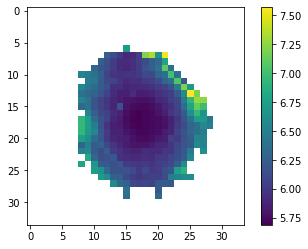

In [7]:
# Calling the functions

objmaps = addDiagnostics('8485','1901')
massMap = getMassMap('8485','1901')
results = findMetallicities(objmaps,massMap)
plt.imshow(results['N2']['metallicity'])
plt.colorbar()